In [15]:
import pandas as pd
import numpy as np
import gc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from scipy.sparse import csr_matrix,bmat
from sklearn.model_selection import KFold,GroupKFold,GroupShuffleSplit

from sklearn.utils import shuffle
import xgboost as xgb
from bayes_opt import BayesianOptimization
import pickle
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

In [3]:
def make_natural_spline_matrix(x,df):
    t = np.percentile(x,np.linspace(0,100,df+2)[1:-1])
    #print t
    X = np.column_stack(([1.0]*len(x),x))
    def d(x,e_k,e_K):
        def pos(x,e):
            x_ = np.copy(x)
            x_[x<=e] = 0.0
            x_[x>e] = (x_[x>e]-e)**3
            return x_
        return (pos(np.copy(x),e_k) - pos(np.copy(x),e_K))/(e_K-e_k)
    for k in range(1,len(t)-1):
        X = np.column_stack((X,d(np.copy(x),t[k],t[-1]) - d(np.copy(x),t[k-1],t[-1])))
    return X

In [165]:
lcv = LassoCV(eps=0.001, n_alphas=13, alphas=None, fit_intercept=True, normalize=True, 
              precompute='auto', max_iter=10000, tol=0.0001, copy_X=True, cv=None, 
              verbose=False, n_jobs=1, positive=False, random_state=None, selection='cyclic')

In [166]:
lcv.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=13, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

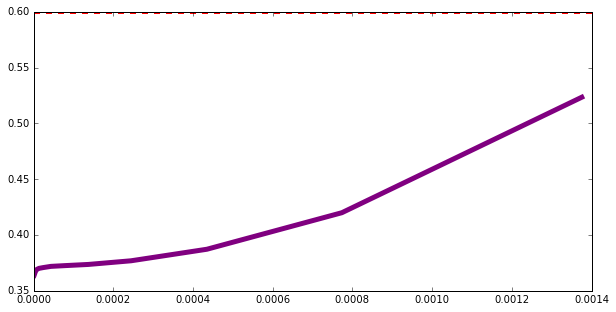

In [167]:
plt.figure(figsize=(10,5))
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1),lw=5,c='purple',label='Mean of 50 Folds');
plt.axhline(np.var(y),label='MSE of Prediction with Mean',lw=2,ls='--',c='r');

In [4]:
def tensor_product(mats):
    if len(mats)<2:
        return "I need at least two mats!"
    first = True
    while mats:
        if first:
            res = np.hstack(mats[0].T[:,:,None] * mats[1][None,:,:])
            mats = mats[2:]
            first = False
        else:
            res = np.hstack(res.T[:,:,None] * mats[0][None,:,:])
            mats = mats[1:]
    return res

In [173]:
cols = 
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])
data = data[data.Cat=='Primary Rough']

y = data.Shots_taken_from_location.values
X_dist = make_natural_spline_matrix(data.Distance_from_hole,15)
X_elev = make_natural_spline_matrix(data.Started_at_Z,8)
X_gtww = make_natural_spline_matrix(data.Green_to_work_with,6)

In [142]:
dfs = [10,12,14,16],[5,7,9],[4,6,8]

In [180]:
import itertools
from collections import defaultdict

In [ ]:
results = defaultdict(list)
for df_1,df_2,df_3 in itertools.product(*dfs):
    
    ## train data
    data = feather.read_dataframe('./../difficulty.feather')
    data = data[data.Cat=='Primary Rough']
    data.loc[data.Green_to_work_with.isnull(),'Green_to_work_with'] = \
            data.Green_to_work_with[data.Green_to_work_with.notnull()].mean()
    np.random.seed(45)
    samp = np.random.choice(range(len(data)),300000 if len(data)>300000 else len(data),replace=False)
    data = data.iloc[samp,:]
    y = data.Shots_taken_from_location.values
    X_dist = make_natural_spline_matrix(data.Distance_from_hole,df_1)
    X_elev = make_natural_spline_matrix(data.Started_at_Z,df_2)
    X_gtww = make_natural_spline_matrix(data.Green_to_work_with,df_3)
    data = None
    gc.collect()
    X = np.hstack((X_dist,X_elev,X_gtww,tensor_product([X_dist,X_elev,X_gtww])))
    
    ols.fit(X,y)
    
    ## test data
    data = feather.read_dataframe('./../difficulty.feather')
    data = data[data.Cat=='Primary Rough']
    data.loc[data.Green_to_work_with.isnull(),'Green_to_work_with'] = \
            data.Green_to_work_with[data.Green_to_work_with.notnull()].mean()
    np.random.seed(45)
    samp = np.random.choice(range(len(data)),300000 if len(data)>300000 else len(data),replace=False)
    data = data.iloc[samp,:]
    y = data.Shots_taken_from_location.values
    X_dist = make_natural_spline_matrix(data.Distance_from_hole,df_1)
    X_elev = make_natural_spline_matrix(data.Started_at_Z,df_2)
    X_gtww = make_natural_spline_matrix(data.Green_to_work_with,df_3)
    data = None
    gc.collect()
    X = np.hstack((X_dist,X_elev,X_gtww,tensor_product([X_dist,X_elev,X_gtww])))

    score = np.mean((ols.predict(X) - y)**2)
    print (df_1,df_2,df_3), score
    results['df_dist'].append(df_1)
    results['df_elev'].append(df_2)
    results['df_gtww'].append(df_3)
    results['score'].append(score)

(10, 5, 4) 0.360504863426


In [168]:
X = np.hstack((X_dist,X_elev,X_gtww,tensor_product([X_dist,X_elev,X_gtww])))

In [169]:
X.shape

(120000, 749)

In [175]:
np.mean((ols.predict(X)-y)**2)

0.84650474484242744

In [174]:
ols.predict(X)[0:10]

array([ 3.41718366,  3.31505908,  3.89100402,  2.26471657,  3.7197415 ,
        2.70697442,  3.72440969,  3.19579696,  4.11325129,  3.18508876])

In [171]:
ols = LinearRegression()
ols.fit(X,y)
np.mean((ols.predict(X)-y)**2)

0.3572253492620423

In [129]:
ols = LinearRegression()
ols.fit(X,y)
np.mean((ols.predict(X)-y)**2)

0.36196708023836399

In [125]:
ols = LinearRegression()
ols.fit(X,y)
np.mean((ols.predict(X)-y)**2)

0.35792428697401296

In [113]:
ols = LinearRegression(copy_X=True)
ols.fit(X,y)
np.mean((ols.predict(X)-y)**2)

0.35751552030405581

In [6]:
def run(df1,df2,df3):
    errors = []
    for u,cat in enumerate(cats):
        data = None
        gc.collect()
        data = feather.read_dataframe('./../difficulty.feather')
        data = data[data.Cat==cat]
        data.loc[data.Green_to_work_with.isnull(),'Green_to_work_with'] = \
        data.Green_to_work_with[data.Green_to_work_with.notnull()].mean()
        samp = np.random.choice(range(len(data)),40000 if len(data)>40000 else len(data),replace=False)
        data = data.iloc[samp,:]
        
        y = data.values[:,0]
        if cat=='Green':
            X_dist = make_natural_spline_matrix(data.Distance_from_hole,df1[u])
            X_elev = make_natural_spline_matrix(data.Started_at_Z,df3[u])
            data = None
            gc.collect()
            X = np.hstack((X_dist,X_elev,tensor_product([X_dist,X_elev])))
            X_dist,X_elev = None,None
            gc.collect()
        else:
            X_dist = make_natural_spline_matrix(data.Distance_from_hole,df1[u])
            X_gtww = make_natural_spline_matrix(data.Green_to_work_with,df2[u])
            X_elev = make_natural_spline_matrix(data.Started_at_Z,df3[u])
            data = None
            gc.collect()
            X = np.hstack((X_dist,X_gtww,X_elev,tensor_product([X_dist,X_gtww,X_elev])))
            X_dist,X_gtww,X_elev = None,None,None
            gc.collect()
        errors.append(cross_val_score(lcv,X,y,scoring='mean_squared_error',n_jobs=1))
    return errors

In [7]:
np.array(cats)

array(['Green', 'Fairway', 'Intermediate Rough', 'Primary Rough', 'Fringe',
       'Bunker', 'Other'], 
      dtype='|S18')

In [8]:
param_grid = [[14]*7,[7]*7,[8]*7]

In [35]:
data = feather.read_dataframe('./../difficulty.feather')

In [21]:
(((data.Cat=="Green").sum()*0.15510111 +
 (data.Cat=="Fairway").sum()*0.33242987 +
 (data.Cat=="Intermediate Rough").sum()*0.30887963 +
 (data.Cat=="Primary Rough").sum()*0.36587546 +
 (data.Cat=="Fringe").sum()*0.18077784 + 
 (data.Cat=="Bunker").sum()*0.38028543 +
 (data.Cat=="Other").sum()*0.51596645)/len(data))**.5

0.48617642480294376

In [8]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.01, 
                                n_estimators=1000, subsample=.5, 
                                min_weight_fraction_leaf=0.0, max_depth=3)

In [40]:
def run():
    errors = []
    for u,cat in enumerate(cats[::-1]):
        data = None
        gc.collect()
        data = feather.read_dataframe('./../difficulty.feather')
        data = data[data.Cat==cat]
        data.loc[data.Green_to_work_with.isnull(),'Green_to_work_with'] = \
        data.Green_to_work_with[data.Green_to_work_with.notnull()].mean()
        
        y = data.values[:,0]
        if cat=='Green': 
            X = data.values[:,np.array([2,4])]
            data = None
            gc.collect()
        else:
            X = data.values[:,2:]
            data = None
            gc.collect()
        gbr.fit(X,y)
        print cat
        print gbr.feature_importances_
        error = np.mean((gbr.predict(X)-y)**2)
        print error
        errors.append(error)
    return errors

In [27]:
run()

[array([-0.11665466, -0.11131057, -0.11583314]),
 array([-0.3135188 , -0.30775616, -0.31905701]),
 array([-0.29630674, -0.30533181, -0.30735962]),
 array([-0.3609437 , -0.36251877, -0.3633638 ]),
 array([-0.18694726, -0.18624939, -0.18571111]),
 array([-0.38349447, -0.36652894, -0.37572808]),
 array([-0.50196789, -0.50959922, -0.5026008 ])]

In [41]:
run()

Other
[ 0.41335769  0.23836312  0.34827919]
0.493646743899
Bunker
[ 0.53774321  0.19835877  0.26389802]
0.372257282426
Fringe
[ 0.46624475  0.22086954  0.31288571]
0.182508595153
Primary Rough
[ 0.56121132  0.17140679  0.26738189]
0.361347962243
Intermediate Rough
[ 0.56586519  0.19200746  0.24212735]
0.300202209856
Fairway
[ 0.6112764   0.16812388  0.22059972]
0.31740937289
Green
[ 0.69468874  0.30531126]
0.115458066078


[0.4936467438990713,
 0.37225728242567796,
 0.1825085951531437,
 0.36134796224265625,
 0.30020220985632007,
 0.31740937288979143,
 0.11545806607753986]

In [43]:
(((data.Cat=="Green").sum()*0.11545806607753986 +
 (data.Cat=="Fairway").sum()*0.31740937289 +
 (data.Cat=="Intermediate Rough").sum()*0.300202209856 +
 (data.Cat=="Primary Rough").sum()*0.361347962243 +
 (data.Cat=="Fringe").sum()*0.182508595153 + 
 (data.Cat=="Bunker").sum()*0.372257282426 +
 (data.Cat=="Other").sum()*0.493646743899)/len(data))**.5

0.45785217793734079

In [36]:
data = data[data.Cat=="Green"]

In [18]:
X = data.values[:,2:].astype(float)

In [37]:
y = data.values[:,0]

In [38]:
X = data.values[:,np.array([2,4])]
data = None
gc.collect()

7

In [39]:
gbr.fit(X,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [10]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

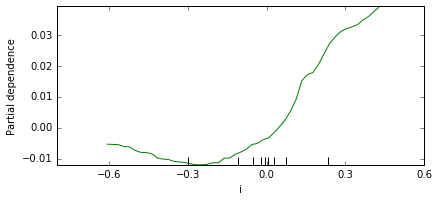

In [41]:
fig,axs = plot_partial_dependence(gbr,X,[1],feature_names='distance',n_jobs=1,grid_resolution=50)

In [7]:
cols = ['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with']
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])

In [8]:
data.insert(len(data.columns),'Year-Course',data.Year.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))
data.insert(len(data.columns),'Hole-Course',data.Hole.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))
data.insert(len(data.columns),'Round-Year-Course',data.Round.astype(str).str.cat([data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))
data.insert(len(data.columns),'Hole-Year-Course',data.Hole.astype(str).str.cat([data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))
data = data.reset_index(drop=True)

In [9]:
with open('./../PickleFiles/xgboost_results.pkl','r') as pickleFile:
    hyperparams = pickle.load(pickleFile)

In [10]:
complexity_choices = ['with_course','with_year-course','with_hole-course','with_round-year-course']
complexity_choice = {'Green':1,'Fairway':3,'Intermediate Rough':3,'Primary Rough':3,'Fringe':0,'Bunker':2,'Other':0}
cols = ['Course_#','Year-Course','Hole-Course','Round-Year-Course','Hole-Year-Course']

In [11]:
le = LabelEncoder()
lb = LabelBinarizer(sparse_output=True)

In [18]:
def fit(gamma,max_depth,alpha,lamb,min_child_weight,subsample):
    params = {'objective':'reg:linear','eta':.15,'gamma':gamma,'max_depth':int(max_depth),'alpha':alpha,'lambda':lamb,
              'min_child_weight':int(min_child_weight),'subsample':subsample,'silent':1,'tree_method':'approx'}
    cv_folds = 5
    early_stopping_rounds = 50
    cv = GroupShuffleSplit(n_splits=cv_folds, test_size=0.2)
    errors = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test],label=y[test])
        watchlist  = [(dtrain,'train'),(dtest,'eval')]
        num_round = 100000
        bst = xgb.train(params,dtrain,num_round,watchlist,early_stopping_rounds=early_stopping_rounds,verbose_eval=False)
        error = np.mean((bst.predict(dtest,ntree_limit=bst.best_iteration) - y[test])**2)
        errors.append(error)
    fit.errors.append(errors)
    return 1/np.array(errors).mean()

In [24]:
#results = defaultdict(dict)
for cat in cats:
    print '******************* DOING %s *******************' % cat
    data_ = data[data.Cat==cat].values
    col_dict = {col:ind for ind,col in enumerate(data.columns)}

    if cat=='Green':
        to_fit = ['Distance_from_hole','Started_at_Z']
    else:
        to_fit = ['Distance_from_hole','Started_at_Z','Green_to_work_with']
    
    y = data_[:,col_dict['Shots_taken_from_location']]
    groups = ['-'.join(map(str,tup)) for tup in data_[:,[col_dict[col] for col in ['Hole','Round','Course_#','Year']]].tolist()]
    groups = le.fit_transform(groups)
    
    for i in range(len(to_fit)):
        if i==0 and cat=='Green':
            continue
        if i==0:
            X = data_[:,col_dict[to_fit[i]]].astype(float)[:,None]
            X = csr_matrix(X)
        else:
            X = bmat([[X,data_[:,col_dict[to_fit[i]]].astype(float)[:,None]]],format='csr')

        print i,X.shape[1]

        fit.errors = []
        xgbBO = BayesianOptimization(fit, {'gamma':(0,4),'max_depth':(2,10),'alpha':(0,.5),
                                             'lamb':(0,4),'min_child_weight':(1,10),'subsample':(.5,1)})

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            xgbBO.maximize(init_points=5,n_iter=25)

        results[cat][i] = (xgbBO.res,fit.errors)

******************* DOING Green *******************
1 2
Initialization
------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |     gamma |      lamb |   max_depth |   min_child_weight |   subsample | 
    1 | 07m13s |    8.63820 |    0.0136 |    3.7270 |    0.8258 |      4.0605 |             4.4926 |      0.8326 | 
    2 | 08m41s |    8.66270 |    0.4396 |    2.6829 |    0.2862 |      6.7861 |             6.7245 |      0.7513 | 
    3 | 09m56s |    8.65294 |    0.0897 |    1.7360 |    2.7111 |      3.9380 |             3.8502 |      0.5952 | 
    4 | 06m24s |    8.64985 |    0.1925 |    3.8623 |    0.6154 |      4.1147 |             9.5704 |      0.9095 | 
    5 | 07m25s |    8.64391 |    0.0524 |    3.8630 |    2.9767 |      5.9769 |             8.4278 |      0.9913 | 
Bayesian Optimization
------------------------------------------------------------------------------------------------

In [35]:
1/results['Green'][0][0]['max']['max_val']

0.11539640862089375

In [36]:
1/results['Green'][1][0]['max']['max_val']

0.1153265254422018

In [34]:
for cat in cats[1:]:
    print cat
    print 1/results[cat][0][0]['max']['max_val']
    print 1/results[cat][1][0]['max']['max_val']
    print 1/results[cat][2][0]['max']['max_val']

Fairway
0.317952383758
0.316956614385
0.316801078398
Intermediate Rough
0.301130965946
0.298694166822
0.299215781164
Primary Rough
0.364109169078
0.362802242105
0.360437663535
Fringe
0.182808380199
0.182053283569
0.182075263576
Bunker
0.373964709285
0.371902854131
0.37124986573
Other
0.496773358398
0.493285056749
0.493501654612


In [39]:
results['Bunker'][0][0]['max']['max_params']

{'alpha': 2.8308109297845888e-09,
 'gamma': 0.19445677028511454,
 'lamb': 0.64217535435683171,
 'max_depth': 5.7678632023109344,
 'min_child_weight': 1.1881875410401355,
 'subsample': 1.0}

In [41]:
def fit(params):
    params.update({'eta':.05,'objective':'reg:linear','max_depth':int(params['max_depth']),
                   'min_child_weight':int(params['min_child_weight']),'silent':1,'tree_method':'approx'})
    early_stopping_rounds = 50
    cv = GroupKFold(n_splits=15)
    r_squareds = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test],label=y[test])
        watchlist  = [(dtrain,'train'),(dtest,'eval')]
        num_round = 100000
        bst = xgb.train(params,dtrain,num_round,watchlist,early_stopping_rounds=early_stopping_rounds,verbose_eval=False)
        error = np.mean((bst.predict(dtest,ntree_limit=bst.best_iteration) - y[test])**2)
        r_squareds.append(1-error/np.var(y[test]))
    return r_squareds

In [ ]:
results2 = defaultdict(dict)
for cat in cats:
    print '******************* DOING %s *******************' % cat
    data_ = data[data.Cat==cat].values
    col_dict = {col:ind for ind,col in enumerate(data.columns)}

    if cat=='Green':
        to_fit = ['Distance_from_hole','Started_at_Z']
    else:
        to_fit = ['Distance_from_hole','Started_at_Z','Green_to_work_with']
    
    y = data_[:,col_dict['Shots_taken_from_location']]
    groups = ['-'.join(map(str,tup)) for tup in data_[:,[col_dict[col] for col in ['Hole','Round','Course_#','Year']]].tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.choice(range(len(groups_dict)),size=len(groups_dict),replace=False)
    groups = [perm[groups_dict[group]] for group in groups]
    
    for i in range(len(to_fit)):
        if i==0:
            X = data_[:,col_dict[to_fit[i]]].astype(float)[:,None]
            X = csr_matrix(X)
        else:
            X = bmat([[X,data_[:,col_dict[to_fit[i]]].astype(float)[:,None]]],format='csr')

        print i,X.shape[1]

        results2[cat][i] = fit(results[cat][i][0]['max']['max_params'])